In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [5]:
state = 'NY'
df = pd.read_csv('us-vaccines.csv').drop(['Code'],1)
vaccines_daily = df[df['Entity']=='New York State']['people_vaccinated'].to_numpy().reshape(-1,1)


States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

# Preprocessing Data

In [8]:
scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
vaccines_cumulative_normalized = scaler.fit_transform(vaccines_daily)

In [9]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [10]:
window_size = 30

X,Y = convert_to_slide_window(vaccines_cumulative_normalized,window_size)
split = int(len(X) * 0.7)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Cumulative + Non-Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Cumulative + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# Non-Cumulative + Non-Normalized
y_test_daily_vaccines = cumulative_to_daily(y_test_inverse)


In [11]:
y_test_inverse.shape

(25, 1)

# TST Model

In [12]:
TST_model = TimeSeriesTransformer(n_features=1,d_model=512, n_heads=8, n_hidden=512, n_layers=8 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}_Vaccine'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.31396453082561493
Epoch 2 Loss is 0.26902900263667107
Epoch 3 Loss is 0.21829600632190704
Epoch 4 Loss is 0.17554031684994698
Epoch 5 Loss is 0.13462839275598526
Epoch 6 Loss is 0.1183994859457016
Epoch 7 Loss is 0.11476731300354004
Epoch 8 Loss is 0.09527276456356049
Epoch 9 Loss is 0.10373230278491974
Epoch 10 Loss is 0.0820739958435297
Epoch 11 Loss is 0.08091113343834877
Epoch 12 Loss is 0.06923053786158562
Epoch 13 Loss is 0.06453482434153557
Epoch 14 Loss is 0.04970649629831314
Epoch 15 Loss is 0.04090581275522709
Epoch 16 Loss is 0.018931888975203037
Epoch 17 Loss is 0.02371088368818164
Epoch 18 Loss is 0.018481205217540264
Epoch 19 Loss is 0.012523919343948364
Epoch 20 Loss is 0.014625684823840857
Epoch 21 Loss is 0.011306448606774211
Epoch 22 Loss is 0.006595564307644963
Epoch 23 Loss is 0.012557277688756585
Epoch 24 Loss is 0.008841582108289003
Epoch 25 Loss is 0.00713303592056036
Epoch 26 Loss is 0.013086186023429036
Epoch 27 Loss is 0.008448116946965456
Ep

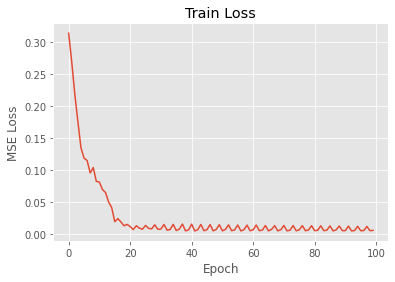

In [13]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [14]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test)

TST: Test MSE Loss:  0.00582192512229085


In [15]:
X_train[-1].shape

torch.Size([30, 1])

In [16]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [17]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 12625409 Parameters for the transformer model


In [18]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST.cpu().detach().numpy())
forecasted_daily_vaccines_TST  = cumulative_to_daily(forecasted_inverse_TST)

In [19]:
print('R2 Score for Vaccines',r2_score(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))

R2 Score for Vaccines 0.6227409259986669
MAPE Score for Vaccines 0.07229302


# LSTM Model

In [20]:
LSTM_model = COVID_LSTM(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}_Vaccine'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.17059744149446487
Epoch 2 Loss is 0.16794712841510773
Epoch 3 Loss is 0.15801911801099777
Epoch 4 Loss is 0.15401481837034225
Epoch 5 Loss is 0.1541665568947792
Epoch 6 Loss is 0.14771129190921783
Epoch 7 Loss is 0.14434271305799484
Epoch 8 Loss is 0.13891678303480148
Epoch 9 Loss is 0.13598067313432693
Epoch 10 Loss is 0.13465196639299393
Epoch 11 Loss is 0.133397426456213
Epoch 12 Loss is 0.13072649389505386
Epoch 13 Loss is 0.13534612953662872
Epoch 14 Loss is 0.13310949504375458
Epoch 15 Loss is 0.12965013086795807
Epoch 16 Loss is 0.13153164088726044
Epoch 17 Loss is 0.1278008073568344
Epoch 18 Loss is 0.12246258184313774
Epoch 19 Loss is 0.11734610795974731
Epoch 20 Loss is 0.11483246833086014
Epoch 21 Loss is 0.1091974526643753
Epoch 22 Loss is 0.10468961670994759
Epoch 23 Loss is 0.1002427339553833
Epoch 24 Loss is 0.09489336982369423
Epoch 25 Loss is 0.0846761204302311
Epoch 26 Loss is 0.0743158869445324
Epoch 27 Loss is 0.06570516899228096
Epoch 28 Loss is 0

In [21]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test)

LSTM: Test MSE Loss:  0.03117174282670021


In [22]:
X_test.shape

torch.Size([25, 30, 1])

In [23]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0577, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [24]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM.cpu().detach().numpy())
forecasted_daily_vaccines_LSTM  = cumulative_to_daily(forecasted_inverse_LSTM)

In [25]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))

R2 Score for Vaccines 0.9973509211803732
MAPE Score for Vaccines 0.4073245


# GRU Model

In [26]:
GRU_model = COVID_GRU(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}_Vaccine'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.1543293371796608
Epoch 2 Loss is 0.14257704839110374
Epoch 3 Loss is 0.13394777476787567
Epoch 4 Loss is 0.1315966621041298
Epoch 5 Loss is 0.12768082320690155
Epoch 6 Loss is 0.12489186227321625
Epoch 7 Loss is 0.12075068801641464
Epoch 8 Loss is 0.11653943732380867
Epoch 9 Loss is 0.11336999386548996
Epoch 10 Loss is 0.10537448897957802
Epoch 11 Loss is 0.0995003916323185
Epoch 12 Loss is 0.09365559741854668
Epoch 13 Loss is 0.08481575176119804
Epoch 14 Loss is 0.07350278086960316
Epoch 15 Loss is 0.0668903086334467
Epoch 16 Loss is 0.05457085557281971
Epoch 17 Loss is 0.044275077059865
Epoch 18 Loss is 0.031660182401537895
Epoch 19 Loss is 0.020054000429809093
Epoch 20 Loss is 0.010357283055782318
Epoch 21 Loss is 0.0033496766118332744
Epoch 22 Loss is 0.0015141937183216214
Epoch 23 Loss is 0.0039990602526813745
Epoch 24 Loss is 0.007705165538936853
Epoch 25 Loss is 0.008822612464427948
Epoch 26 Loss is 0.007420907961204648
Epoch 27 Loss is 0.004630332579836249
Epo

In [27]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test)

GRU: Test MSE Loss:  0.015864819288253784


In [28]:
X_test.shape

torch.Size([25, 30, 1])

In [29]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [30]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU.cpu().detach().numpy())
forecasted_daily_vaccines_GRU  = cumulative_to_daily(forecasted_inverse_GRU)

In [31]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))

R2 Score for Vaccines 0.9988935403349876
MAPE Score for Vaccines 0.36824283


# Plots

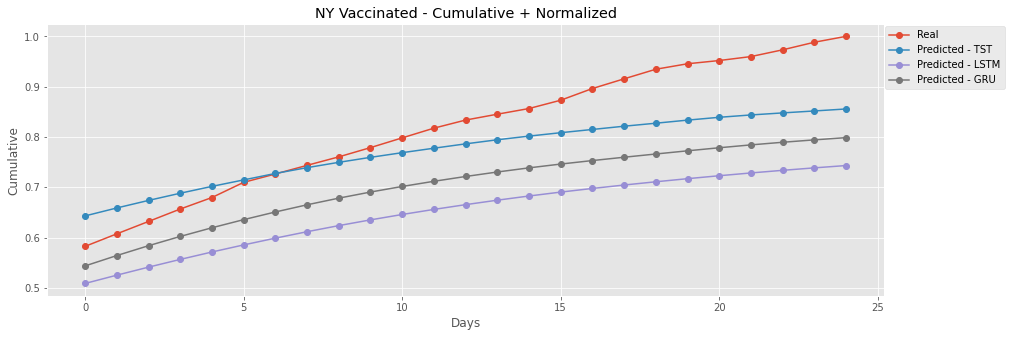

In [32]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0].cpu().detach().numpy(),label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0].cpu().detach().numpy(),label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0].cpu().detach().numpy(),label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

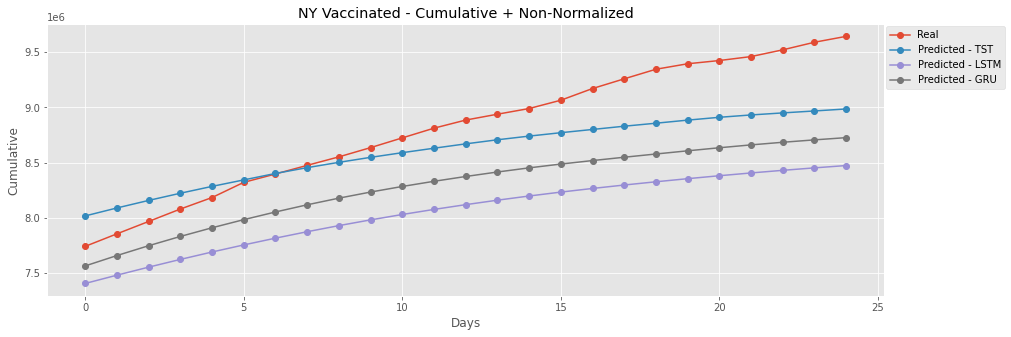

In [33]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

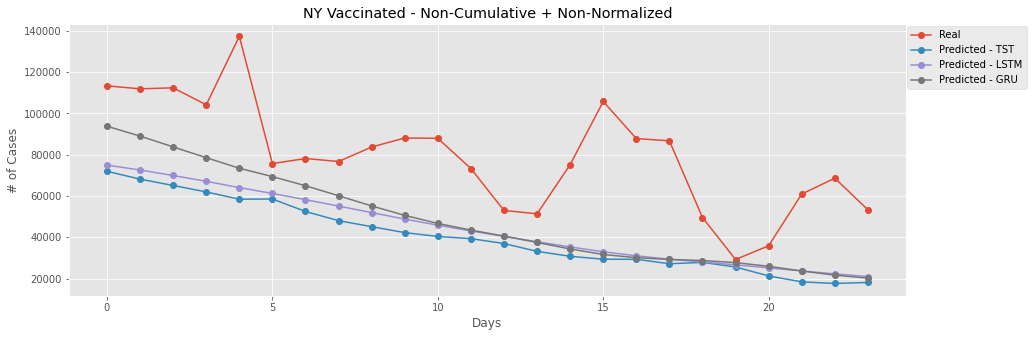

In [34]:
fig, ax = plt.subplots()

plt.plot(y_test_daily_vaccines[1:],label='Real',marker='o')
plt.plot(forecasted_daily_vaccines_TST[1:],label='Predicted - TST',marker='o')
plt.plot(forecasted_daily_vaccines_LSTM[1:],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_daily_vaccines_GRU[1:],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Non-Cumulative + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('# of Cases')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()